# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed-celeba-small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

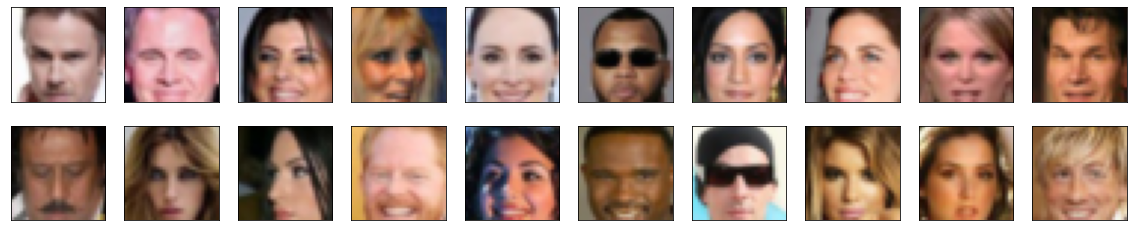

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max-min)+min
    
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8275)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(conv_fn, in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    
    # append convolutional layer
    layers.append(conv_fn(in_channels, out_channels, kernel_size, stride, padding, bias=False))

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # convolutional layers
        self.conv1 = conv(nn.Conv2d, 3, conv_dim, batch_norm=False) # 32x32 -> 16x16, no batch norm
        self.conv2_bn = conv(nn.Conv2d, conv_dim, conv_dim*2) # 16x16 -> 8x8
        self.conv3_bn = conv(nn.Conv2d, conv_dim*2, conv_dim*4) # 8x8 -> 4x4
        self.conv4_bn = conv(nn.Conv2d, conv_dim*4, conv_dim*8) # 4x4 -> 2x2
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2_bn(out), 0.2)
        out = F.leaky_relu(self.conv3_bn(out), 0.2)
        out = F.leaky_relu(self.conv4_bn(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*8*2*2)
        
        # final output layer
        out = self.fc(out)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose convolutional layers
        self.convT1_bn = conv(nn.ConvTranspose2d, conv_dim*8, conv_dim*4) # 2x2 -> 4x4
        self.convT2_bn = conv(nn.ConvTranspose2d, conv_dim*4, conv_dim*2) # 4x4 -> 8x8
        self.convT3_bn = conv(nn.ConvTranspose2d, conv_dim*2, conv_dim) # 8x8 -> 16x16
        self.convT4 = conv(nn.ConvTranspose2d, conv_dim, 3, batch_norm=False) # 16x16 -> 32x32, no batch norm
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 4, 4)
        
        # hidden transpose convolutional layers + relu activation
        out = F.relu(self.convT1_bn(out))
        out = F.relu(self.convT2_bn(out))
        out = F.relu(self.convT3_bn(out))
        
        # last layer + tanh activation
        out = F.tanh(self.convT4(out))
        
        return out
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers

    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    #elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
    #    init.normal_(m.weight.data, 1.0, 0.02)
    #    init.constant_(m.bias.data, 0.0)


## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2_bn): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3_bn): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4_bn): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (convT1_bn): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
#import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out, smoothing=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smoothing:
        labels = torch.ones(batch_size)*0.9 # smooth, real labels = 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out, smoothing=False):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smoothing:
        labels = torch.ones(batch_size)*0.1 # smooth, fake labels = 0.1
    else:
        labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# params
lr = 0.0003  # default = 0.001
betas = (0.5, 0.999)  # default = (0.9, 0.999)

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, betas)
g_optimizer = optim.Adam(G.parameters(), lr, betas)

# Create schedulers for adjusting the learning rate
d_scheduler = optim.lr_scheduler.StepLR(d_optimizer, step_size=2, gamma=0.95)
g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=2, gamma=0.85)


---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def noise(sample_size, z_size):
    # Generate fake images
    z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    z = torch.from_numpy(z).float()
    return z

In [20]:
def view_samples(epoch, samples):
    # view a list of passed in sample images
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = noise(sample_size, z_size)
    # move fixed_z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images

            d_optimizer.zero_grad()

            # 1.1 Train with real images

            # Compute the discriminator losses on real images 
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smoothing=True)

            # 1.2 Train with fake images

            # Generate fake images
            z = noise(batch_size, z_size)
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake, smoothing=True)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()

            # 2.1 Train with fake images and flipped labels

            # Generate fake images
            z = noise(batch_size, z_size)
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake, smoothing=True) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH ##    
        # adjust learning rate
        d_scheduler.step()
        g_scheduler.step()
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        view_samples(-1, samples)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   20] | d_loss: 1.5384 | g_loss: 1.8727
Epoch [    1/   20] | d_loss: 1.0634 | g_loss: 1.8177
Epoch [    1/   20] | d_loss: 0.8601 | g_loss: 2.1814
Epoch [    1/   20] | d_loss: 1.0740 | g_loss: 3.0524
Epoch [    1/   20] | d_loss: 1.1620 | g_loss: 3.2059
Epoch [    1/   20] | d_loss: 1.2332 | g_loss: 3.8390
Epoch [    1/   20] | d_loss: 1.1517 | g_loss: 1.4193
Epoch [    1/   20] | d_loss: 1.5919 | g_loss: 1.6158
Epoch [    1/   20] | d_loss: 1.2311 | g_loss: 3.6581
Epoch [    1/   20] | d_loss: 0.9557 | g_loss: 1.6455
Epoch [    1/   20] | d_loss: 0.9823 | g_loss: 1.8931
Epoch [    1/   20] | d_loss: 1.0770 | g_loss: 1.6022
Epoch [    1/   20] | d_loss: 1.0569 | g_loss: 1.2254
Epoch [    1/   20] | d_loss: 1.0124 | g_loss: 1.8241
Epoch [    1/   20] | d_loss: 1.0721 | g_loss: 1.4523


Epoch [    2/   20] | d_loss: 1.1698 | g_loss: 0.8202
Epoch [    2/   20] | d_loss: 1.0326 | g_loss: 2.8621
Epoch [    2/   20] | d_loss: 1.1123 | g_loss: 1.3584
Epoch [    2/   20] | d_loss: 1.0449 | g_loss: 2.1047
Epoch [    2/   20] | d_loss: 1.3378 | g_loss: 1.8770
Epoch [    2/   20] | d_loss: 0.9988 | g_loss: 1.5521
Epoch [    2/   20] | d_loss: 1.0780 | g_loss: 2.3602
Epoch [    2/   20] | d_loss: 0.9691 | g_loss: 1.5053
Epoch [    2/   20] | d_loss: 1.0593 | g_loss: 2.4304
Epoch [    2/   20] | d_loss: 1.0998 | g_loss: 1.4454
Epoch [    2/   20] | d_loss: 1.1340 | g_loss: 1.1142
Epoch [    2/   20] | d_loss: 0.9916 | g_loss: 1.6842
Epoch [    2/   20] | d_loss: 1.1565 | g_loss: 1.1784
Epoch [    2/   20] | d_loss: 1.2470 | g_loss: 1.2358
Epoch [    2/   20] | d_loss: 1.0415 | g_loss: 2.0864


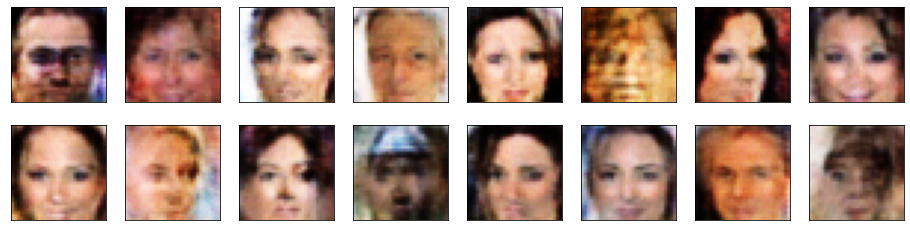

Epoch [    3/   20] | d_loss: 1.0347 | g_loss: 2.0300
Epoch [    3/   20] | d_loss: 1.2768 | g_loss: 2.5550
Epoch [    3/   20] | d_loss: 0.9804 | g_loss: 2.0174
Epoch [    3/   20] | d_loss: 1.0698 | g_loss: 1.2815
Epoch [    3/   20] | d_loss: 1.0569 | g_loss: 1.8461
Epoch [    3/   20] | d_loss: 1.0090 | g_loss: 1.9107
Epoch [    3/   20] | d_loss: 1.0126 | g_loss: 2.4189
Epoch [    3/   20] | d_loss: 1.0320 | g_loss: 1.6698
Epoch [    3/   20] | d_loss: 1.0160 | g_loss: 1.9744
Epoch [    3/   20] | d_loss: 1.0231 | g_loss: 1.4600
Epoch [    3/   20] | d_loss: 1.1983 | g_loss: 1.0354
Epoch [    3/   20] | d_loss: 0.9981 | g_loss: 1.7467
Epoch [    3/   20] | d_loss: 0.9485 | g_loss: 1.3380
Epoch [    3/   20] | d_loss: 1.0985 | g_loss: 1.5159
Epoch [    3/   20] | d_loss: 0.9632 | g_loss: 1.2909


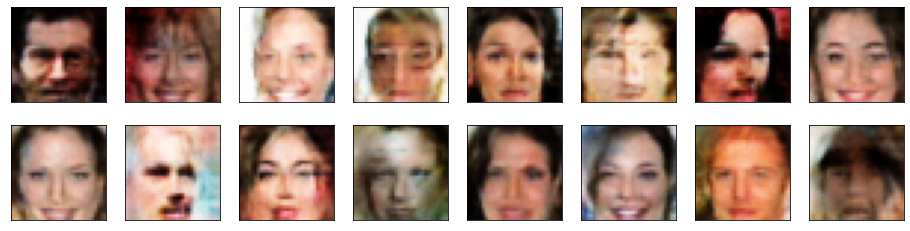

Epoch [    4/   20] | d_loss: 0.9692 | g_loss: 1.7561
Epoch [    4/   20] | d_loss: 1.0524 | g_loss: 1.8385
Epoch [    4/   20] | d_loss: 0.9831 | g_loss: 1.2425
Epoch [    4/   20] | d_loss: 1.0520 | g_loss: 2.4498
Epoch [    4/   20] | d_loss: 1.1583 | g_loss: 2.8921
Epoch [    4/   20] | d_loss: 1.1602 | g_loss: 1.0725
Epoch [    4/   20] | d_loss: 0.9183 | g_loss: 1.8480
Epoch [    4/   20] | d_loss: 0.9829 | g_loss: 1.3780
Epoch [    4/   20] | d_loss: 1.0219 | g_loss: 1.6558
Epoch [    4/   20] | d_loss: 1.0488 | g_loss: 1.4446
Epoch [    4/   20] | d_loss: 1.0074 | g_loss: 1.7348
Epoch [    4/   20] | d_loss: 1.0266 | g_loss: 1.1321
Epoch [    4/   20] | d_loss: 1.1778 | g_loss: 1.0363
Epoch [    4/   20] | d_loss: 1.1252 | g_loss: 1.0625
Epoch [    4/   20] | d_loss: 1.0188 | g_loss: 2.3866


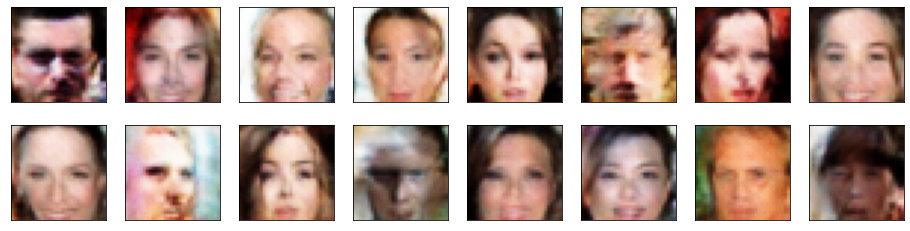

Epoch [    5/   20] | d_loss: 0.9315 | g_loss: 2.2961
Epoch [    5/   20] | d_loss: 1.1840 | g_loss: 2.1763
Epoch [    5/   20] | d_loss: 1.0792 | g_loss: 1.6283
Epoch [    5/   20] | d_loss: 0.9308 | g_loss: 1.2980
Epoch [    5/   20] | d_loss: 1.3872 | g_loss: 2.8428
Epoch [    5/   20] | d_loss: 1.0708 | g_loss: 1.8903
Epoch [    5/   20] | d_loss: 0.9751 | g_loss: 1.3258
Epoch [    5/   20] | d_loss: 0.9365 | g_loss: 1.3214
Epoch [    5/   20] | d_loss: 1.0094 | g_loss: 1.1519
Epoch [    5/   20] | d_loss: 1.0235 | g_loss: 1.6338
Epoch [    5/   20] | d_loss: 0.8890 | g_loss: 1.2806
Epoch [    5/   20] | d_loss: 1.0347 | g_loss: 1.2984
Epoch [    5/   20] | d_loss: 1.0793 | g_loss: 1.1260
Epoch [    5/   20] | d_loss: 0.9165 | g_loss: 1.6729
Epoch [    5/   20] | d_loss: 0.9395 | g_loss: 1.1459


Epoch [    6/   20] | d_loss: 0.9454 | g_loss: 1.7959
Epoch [    6/   20] | d_loss: 1.0348 | g_loss: 1.9176
Epoch [    6/   20] | d_loss: 1.0292 | g_loss: 1.7092
Epoch [    6/   20] | d_loss: 1.1041 | g_loss: 0.9562
Epoch [    6/   20] | d_loss: 1.0961 | g_loss: 0.9269
Epoch [    6/   20] | d_loss: 0.9428 | g_loss: 1.4409
Epoch [    6/   20] | d_loss: 1.0783 | g_loss: 1.5971
Epoch [    6/   20] | d_loss: 0.9013 | g_loss: 1.8317
Epoch [    6/   20] | d_loss: 1.0210 | g_loss: 1.7470
Epoch [    6/   20] | d_loss: 0.8933 | g_loss: 1.7078
Epoch [    6/   20] | d_loss: 1.0699 | g_loss: 1.5325
Epoch [    6/   20] | d_loss: 1.0524 | g_loss: 1.0556
Epoch [    6/   20] | d_loss: 0.9518 | g_loss: 1.6941
Epoch [    6/   20] | d_loss: 1.0480 | g_loss: 2.3860
Epoch [    6/   20] | d_loss: 1.0731 | g_loss: 1.2914


Epoch [    7/   20] | d_loss: 1.0125 | g_loss: 1.6298
Epoch [    7/   20] | d_loss: 0.9689 | g_loss: 1.0594
Epoch [    7/   20] | d_loss: 1.0038 | g_loss: 1.3853
Epoch [    7/   20] | d_loss: 0.9800 | g_loss: 1.9836
Epoch [    7/   20] | d_loss: 0.7546 | g_loss: 2.4649
Epoch [    7/   20] | d_loss: 0.9561 | g_loss: 1.7705
Epoch [    7/   20] | d_loss: 0.9585 | g_loss: 2.4149
Epoch [    7/   20] | d_loss: 0.8645 | g_loss: 2.0072
Epoch [    7/   20] | d_loss: 0.8722 | g_loss: 1.6227
Epoch [    7/   20] | d_loss: 0.9231 | g_loss: 1.7868
Epoch [    7/   20] | d_loss: 1.2173 | g_loss: 0.9345
Epoch [    7/   20] | d_loss: 1.1643 | g_loss: 1.2268
Epoch [    7/   20] | d_loss: 0.9238 | g_loss: 2.4596
Epoch [    7/   20] | d_loss: 0.8460 | g_loss: 1.8839
Epoch [    7/   20] | d_loss: 0.8287 | g_loss: 1.8445


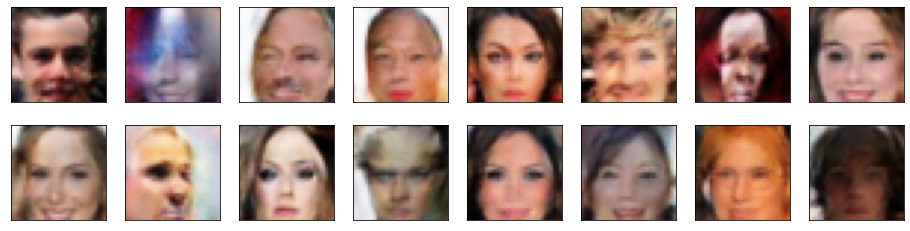

Epoch [    8/   20] | d_loss: 0.9599 | g_loss: 1.7211
Epoch [    8/   20] | d_loss: 0.8713 | g_loss: 1.5094
Epoch [    8/   20] | d_loss: 0.9035 | g_loss: 1.8908
Epoch [    8/   20] | d_loss: 1.3273 | g_loss: 2.2057
Epoch [    8/   20] | d_loss: 0.9439 | g_loss: 1.3946
Epoch [    8/   20] | d_loss: 0.8851 | g_loss: 2.4155
Epoch [    8/   20] | d_loss: 0.8253 | g_loss: 1.5689
Epoch [    8/   20] | d_loss: 1.1325 | g_loss: 2.7525
Epoch [    8/   20] | d_loss: 0.8224 | g_loss: 1.5017
Epoch [    8/   20] | d_loss: 0.7471 | g_loss: 2.6410
Epoch [    8/   20] | d_loss: 0.8218 | g_loss: 1.7406
Epoch [    8/   20] | d_loss: 0.8284 | g_loss: 1.9516
Epoch [    8/   20] | d_loss: 1.2275 | g_loss: 1.0238
Epoch [    8/   20] | d_loss: 1.2370 | g_loss: 1.5688
Epoch [    8/   20] | d_loss: 0.8116 | g_loss: 1.6756


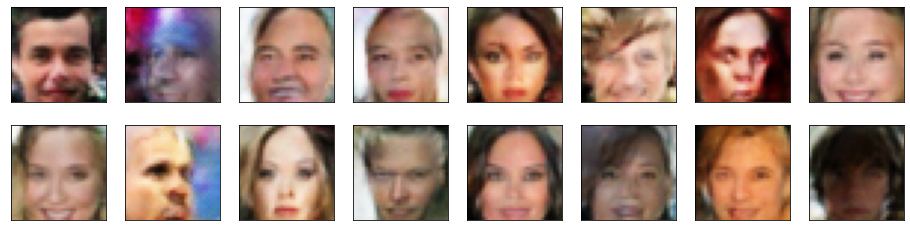

Epoch [    9/   20] | d_loss: 0.7677 | g_loss: 2.0482
Epoch [    9/   20] | d_loss: 0.8008 | g_loss: 1.9140
Epoch [    9/   20] | d_loss: 0.8475 | g_loss: 1.3149
Epoch [    9/   20] | d_loss: 1.0035 | g_loss: 1.1995
Epoch [    9/   20] | d_loss: 0.7704 | g_loss: 1.7829
Epoch [    9/   20] | d_loss: 0.8124 | g_loss: 1.6367
Epoch [    9/   20] | d_loss: 0.8987 | g_loss: 1.2822
Epoch [    9/   20] | d_loss: 0.8543 | g_loss: 2.3466
Epoch [    9/   20] | d_loss: 0.8414 | g_loss: 1.9118
Epoch [    9/   20] | d_loss: 0.8084 | g_loss: 1.6848
Epoch [    9/   20] | d_loss: 2.6214 | g_loss: 3.8364
Epoch [    9/   20] | d_loss: 0.8920 | g_loss: 1.8992
Epoch [    9/   20] | d_loss: 0.8144 | g_loss: 1.0379
Epoch [    9/   20] | d_loss: 1.0120 | g_loss: 2.5539
Epoch [    9/   20] | d_loss: 0.8392 | g_loss: 1.6673


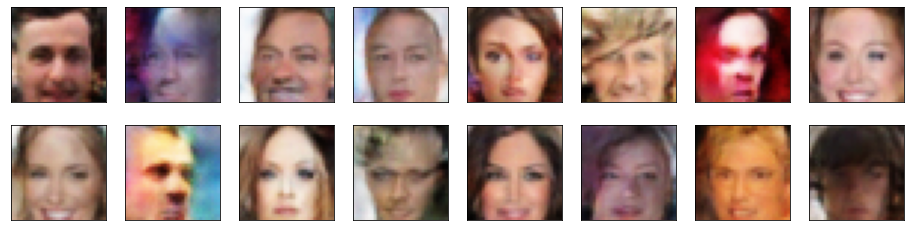

Epoch [   10/   20] | d_loss: 1.0500 | g_loss: 3.1090
Epoch [   10/   20] | d_loss: 0.9723 | g_loss: 0.7852
Epoch [   10/   20] | d_loss: 0.8591 | g_loss: 2.0571
Epoch [   10/   20] | d_loss: 0.8920 | g_loss: 2.0925
Epoch [   10/   20] | d_loss: 0.7513 | g_loss: 1.5123
Epoch [   10/   20] | d_loss: 0.8067 | g_loss: 2.0839
Epoch [   10/   20] | d_loss: 0.9241 | g_loss: 2.2720
Epoch [   10/   20] | d_loss: 1.0582 | g_loss: 1.1456
Epoch [   10/   20] | d_loss: 0.8512 | g_loss: 1.6804
Epoch [   10/   20] | d_loss: 0.9490 | g_loss: 1.1624
Epoch [   10/   20] | d_loss: 1.0450 | g_loss: 1.1468
Epoch [   10/   20] | d_loss: 0.9821 | g_loss: 2.4447
Epoch [   10/   20] | d_loss: 0.8374 | g_loss: 1.7551
Epoch [   10/   20] | d_loss: 0.8334 | g_loss: 1.7981
Epoch [   10/   20] | d_loss: 0.8573 | g_loss: 1.6751


Epoch [   11/   20] | d_loss: 0.8262 | g_loss: 2.2468
Epoch [   11/   20] | d_loss: 0.8186 | g_loss: 1.4223
Epoch [   11/   20] | d_loss: 0.7766 | g_loss: 1.2501
Epoch [   11/   20] | d_loss: 0.8028 | g_loss: 1.4175
Epoch [   11/   20] | d_loss: 0.8937 | g_loss: 1.4212
Epoch [   11/   20] | d_loss: 0.8207 | g_loss: 1.4616
Epoch [   11/   20] | d_loss: 0.7745 | g_loss: 2.0745
Epoch [   11/   20] | d_loss: 0.9874 | g_loss: 0.9029
Epoch [   11/   20] | d_loss: 0.8237 | g_loss: 1.3715
Epoch [   11/   20] | d_loss: 0.7898 | g_loss: 1.8369
Epoch [   11/   20] | d_loss: 0.8201 | g_loss: 1.7353
Epoch [   11/   20] | d_loss: 0.9074 | g_loss: 1.2405
Epoch [   11/   20] | d_loss: 0.9800 | g_loss: 2.5500
Epoch [   11/   20] | d_loss: 0.8497 | g_loss: 1.8604
Epoch [   11/   20] | d_loss: 1.2648 | g_loss: 1.2560


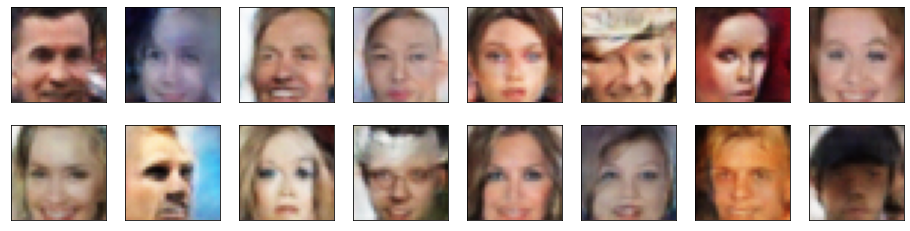

Epoch [   12/   20] | d_loss: 0.8056 | g_loss: 1.9817
Epoch [   12/   20] | d_loss: 0.7271 | g_loss: 1.9279
Epoch [   12/   20] | d_loss: 0.8644 | g_loss: 2.8669
Epoch [   12/   20] | d_loss: 0.7093 | g_loss: 2.5663
Epoch [   12/   20] | d_loss: 0.7979 | g_loss: 2.3604
Epoch [   12/   20] | d_loss: 0.7748 | g_loss: 1.8913
Epoch [   12/   20] | d_loss: 0.7688 | g_loss: 2.0893
Epoch [   12/   20] | d_loss: 0.9788 | g_loss: 3.1376
Epoch [   12/   20] | d_loss: 0.7551 | g_loss: 1.5933
Epoch [   12/   20] | d_loss: 1.1062 | g_loss: 2.7419
Epoch [   12/   20] | d_loss: 0.7959 | g_loss: 1.4765
Epoch [   12/   20] | d_loss: 1.2197 | g_loss: 1.2833
Epoch [   12/   20] | d_loss: 0.7389 | g_loss: 1.8395
Epoch [   12/   20] | d_loss: 0.7999 | g_loss: 1.5259
Epoch [   12/   20] | d_loss: 0.8859 | g_loss: 2.5231


Epoch [   13/   20] | d_loss: 0.9384 | g_loss: 2.4455
Epoch [   13/   20] | d_loss: 0.7331 | g_loss: 2.0216
Epoch [   13/   20] | d_loss: 0.7201 | g_loss: 2.2641
Epoch [   13/   20] | d_loss: 0.7870 | g_loss: 1.6092
Epoch [   13/   20] | d_loss: 0.7842 | g_loss: 1.4537
Epoch [   13/   20] | d_loss: 0.8568 | g_loss: 2.1396
Epoch [   13/   20] | d_loss: 0.7693 | g_loss: 2.1380
Epoch [   13/   20] | d_loss: 0.7758 | g_loss: 2.2402
Epoch [   13/   20] | d_loss: 0.9405 | g_loss: 1.6357
Epoch [   13/   20] | d_loss: 0.7487 | g_loss: 1.2422
Epoch [   13/   20] | d_loss: 0.7682 | g_loss: 1.2441
Epoch [   13/   20] | d_loss: 0.7526 | g_loss: 1.6815
Epoch [   13/   20] | d_loss: 0.7829 | g_loss: 2.9842
Epoch [   13/   20] | d_loss: 0.7087 | g_loss: 2.0621
Epoch [   13/   20] | d_loss: 0.7467 | g_loss: 2.0886


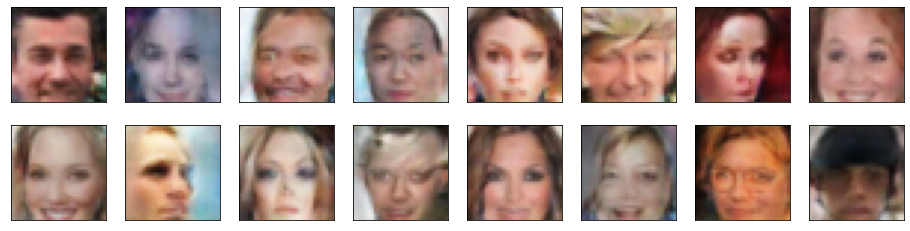

Epoch [   14/   20] | d_loss: 0.9767 | g_loss: 1.0674
Epoch [   14/   20] | d_loss: 0.7102 | g_loss: 2.9210
Epoch [   14/   20] | d_loss: 0.7374 | g_loss: 1.8811
Epoch [   14/   20] | d_loss: 0.9611 | g_loss: 2.4549
Epoch [   14/   20] | d_loss: 0.9509 | g_loss: 1.1446
Epoch [   14/   20] | d_loss: 0.7209 | g_loss: 1.4278
Epoch [   14/   20] | d_loss: 0.7409 | g_loss: 2.2225
Epoch [   14/   20] | d_loss: 1.0627 | g_loss: 1.0257
Epoch [   14/   20] | d_loss: 0.7660 | g_loss: 1.9701
Epoch [   14/   20] | d_loss: 0.8627 | g_loss: 1.9207
Epoch [   14/   20] | d_loss: 0.7864 | g_loss: 1.5170
Epoch [   14/   20] | d_loss: 0.7520 | g_loss: 1.9219
Epoch [   14/   20] | d_loss: 0.7409 | g_loss: 1.8976
Epoch [   14/   20] | d_loss: 0.7327 | g_loss: 1.7465
Epoch [   14/   20] | d_loss: 0.7467 | g_loss: 1.9692


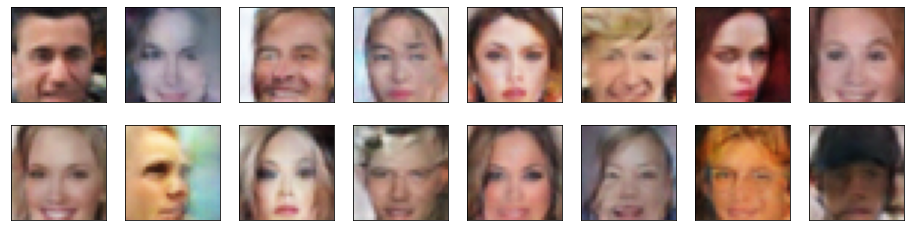

Epoch [   15/   20] | d_loss: 0.7508 | g_loss: 2.2547
Epoch [   15/   20] | d_loss: 0.8569 | g_loss: 1.3211
Epoch [   15/   20] | d_loss: 0.7288 | g_loss: 2.2481
Epoch [   15/   20] | d_loss: 0.8093 | g_loss: 3.0858
Epoch [   15/   20] | d_loss: 0.8700 | g_loss: 2.2235
Epoch [   15/   20] | d_loss: 0.7759 | g_loss: 1.7512
Epoch [   15/   20] | d_loss: 0.7282 | g_loss: 2.0714
Epoch [   15/   20] | d_loss: 0.7877 | g_loss: 1.8631
Epoch [   15/   20] | d_loss: 0.7448 | g_loss: 1.8772
Epoch [   15/   20] | d_loss: 0.7949 | g_loss: 1.6155
Epoch [   15/   20] | d_loss: 0.7151 | g_loss: 2.1053
Epoch [   15/   20] | d_loss: 0.8364 | g_loss: 1.7602
Epoch [   15/   20] | d_loss: 0.7885 | g_loss: 2.0897
Epoch [   15/   20] | d_loss: 0.6956 | g_loss: 1.7379
Epoch [   15/   20] | d_loss: 0.8139 | g_loss: 2.6457


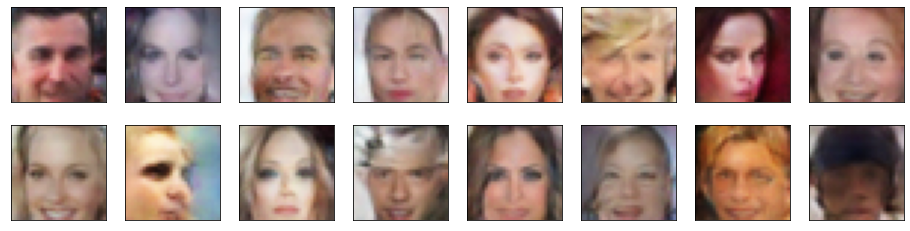

Epoch [   16/   20] | d_loss: 0.7773 | g_loss: 2.5368
Epoch [   16/   20] | d_loss: 0.6854 | g_loss: 2.1478
Epoch [   16/   20] | d_loss: 0.7583 | g_loss: 2.0254
Epoch [   16/   20] | d_loss: 0.7521 | g_loss: 1.6551
Epoch [   16/   20] | d_loss: 0.7394 | g_loss: 2.3409
Epoch [   16/   20] | d_loss: 0.7712 | g_loss: 1.8442
Epoch [   16/   20] | d_loss: 0.7675 | g_loss: 1.2179
Epoch [   16/   20] | d_loss: 0.9150 | g_loss: 1.3297
Epoch [   16/   20] | d_loss: 0.7127 | g_loss: 1.8543
Epoch [   16/   20] | d_loss: 0.7376 | g_loss: 2.2661
Epoch [   16/   20] | d_loss: 0.7505 | g_loss: 2.3034
Epoch [   16/   20] | d_loss: 0.8087 | g_loss: 1.9415
Epoch [   16/   20] | d_loss: 0.7167 | g_loss: 1.4156
Epoch [   16/   20] | d_loss: 0.7020 | g_loss: 1.8552
Epoch [   16/   20] | d_loss: 0.9564 | g_loss: 0.9245


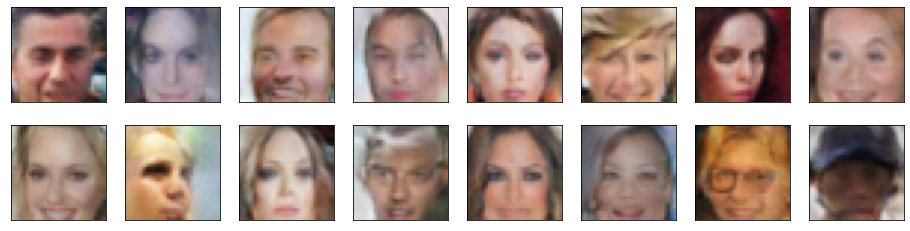

Epoch [   17/   20] | d_loss: 2.2722 | g_loss: 4.0264
Epoch [   17/   20] | d_loss: 0.7944 | g_loss: 1.4189
Epoch [   17/   20] | d_loss: 0.7931 | g_loss: 1.7070
Epoch [   17/   20] | d_loss: 0.6919 | g_loss: 1.9890
Epoch [   17/   20] | d_loss: 0.7507 | g_loss: 1.7684
Epoch [   17/   20] | d_loss: 0.7120 | g_loss: 2.0035
Epoch [   17/   20] | d_loss: 0.7119 | g_loss: 1.8974
Epoch [   17/   20] | d_loss: 0.7314 | g_loss: 1.7122
Epoch [   17/   20] | d_loss: 0.7755 | g_loss: 2.5680
Epoch [   17/   20] | d_loss: 0.6943 | g_loss: 2.4450
Epoch [   17/   20] | d_loss: 0.6983 | g_loss: 1.9631
Epoch [   17/   20] | d_loss: 0.7431 | g_loss: 2.6729
Epoch [   17/   20] | d_loss: 0.7198 | g_loss: 1.7668
Epoch [   17/   20] | d_loss: 0.7636 | g_loss: 1.0895
Epoch [   17/   20] | d_loss: 0.7079 | g_loss: 2.0343


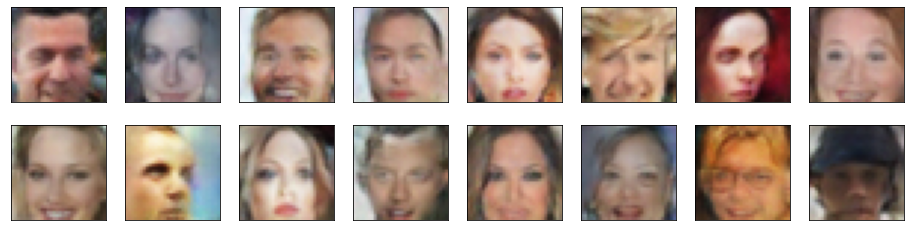

Epoch [   18/   20] | d_loss: 0.7185 | g_loss: 2.5840
Epoch [   18/   20] | d_loss: 0.7979 | g_loss: 1.9533
Epoch [   18/   20] | d_loss: 0.7221 | g_loss: 1.7859
Epoch [   18/   20] | d_loss: 0.8039 | g_loss: 1.3985
Epoch [   18/   20] | d_loss: 1.0014 | g_loss: 2.9654
Epoch [   18/   20] | d_loss: 0.7074 | g_loss: 2.0100
Epoch [   18/   20] | d_loss: 0.7375 | g_loss: 2.3427
Epoch [   18/   20] | d_loss: 0.7662 | g_loss: 1.7672
Epoch [   18/   20] | d_loss: 0.8070 | g_loss: 1.4570
Epoch [   18/   20] | d_loss: 0.7766 | g_loss: 1.1717
Epoch [   18/   20] | d_loss: 0.7710 | g_loss: 1.1302
Epoch [   18/   20] | d_loss: 0.8895 | g_loss: 1.1371
Epoch [   18/   20] | d_loss: 0.7338 | g_loss: 1.4880
Epoch [   18/   20] | d_loss: 0.7685 | g_loss: 2.0973
Epoch [   18/   20] | d_loss: 0.6997 | g_loss: 1.5587


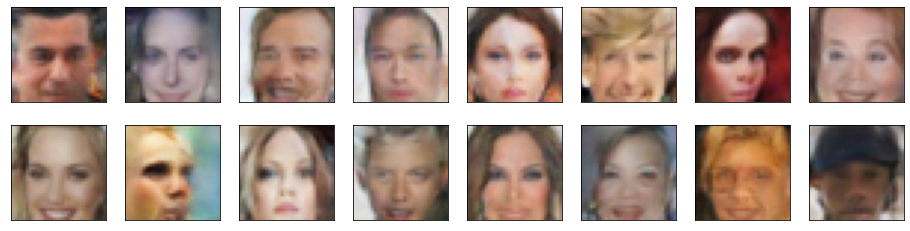

Epoch [   19/   20] | d_loss: 0.8409 | g_loss: 1.4155
Epoch [   19/   20] | d_loss: 0.7055 | g_loss: 1.6116
Epoch [   19/   20] | d_loss: 0.7344 | g_loss: 2.0191
Epoch [   19/   20] | d_loss: 0.7448 | g_loss: 1.6229
Epoch [   19/   20] | d_loss: 0.6953 | g_loss: 2.2034
Epoch [   19/   20] | d_loss: 0.7190 | g_loss: 2.0316
Epoch [   19/   20] | d_loss: 0.7177 | g_loss: 2.0220
Epoch [   19/   20] | d_loss: 0.7278 | g_loss: 1.4665
Epoch [   19/   20] | d_loss: 0.7163 | g_loss: 1.7325
Epoch [   19/   20] | d_loss: 0.7311 | g_loss: 1.7039
Epoch [   19/   20] | d_loss: 0.7142 | g_loss: 2.2212
Epoch [   19/   20] | d_loss: 0.6880 | g_loss: 2.2331
Epoch [   19/   20] | d_loss: 0.8181 | g_loss: 2.0661
Epoch [   19/   20] | d_loss: 0.8727 | g_loss: 3.2029
Epoch [   19/   20] | d_loss: 0.8675 | g_loss: 1.2775


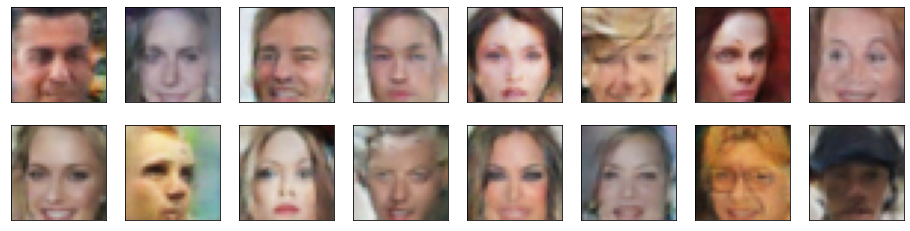

Epoch [   20/   20] | d_loss: 1.0461 | g_loss: 2.9054
Epoch [   20/   20] | d_loss: 0.7363 | g_loss: 2.6767
Epoch [   20/   20] | d_loss: 0.7351 | g_loss: 2.2349
Epoch [   20/   20] | d_loss: 0.7578 | g_loss: 1.6518
Epoch [   20/   20] | d_loss: 0.7566 | g_loss: 2.7171
Epoch [   20/   20] | d_loss: 0.7133 | g_loss: 2.3364
Epoch [   20/   20] | d_loss: 0.7203 | g_loss: 2.5999
Epoch [   20/   20] | d_loss: 0.7880 | g_loss: 2.3636
Epoch [   20/   20] | d_loss: 0.7668 | g_loss: 1.8776
Epoch [   20/   20] | d_loss: 0.7247 | g_loss: 1.9202
Epoch [   20/   20] | d_loss: 0.6818 | g_loss: 1.8446
Epoch [   20/   20] | d_loss: 0.7129 | g_loss: 1.8884
Epoch [   20/   20] | d_loss: 0.6943 | g_loss: 2.1246
Epoch [   20/   20] | d_loss: 0.7936 | g_loss: 2.1530
Epoch [   20/   20] | d_loss: 0.9853 | g_loss: 1.4622


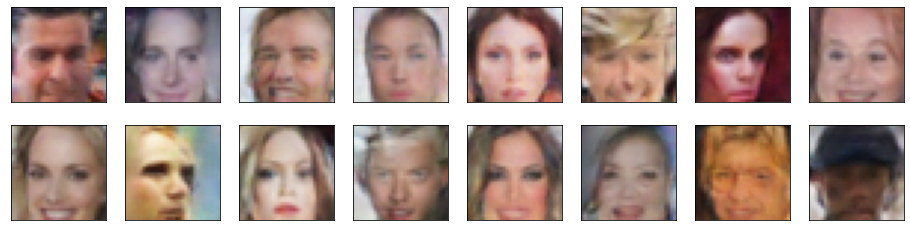

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [22]:
# set number of epochs 
n_epochs = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [23]:
def plot_losses(losses):
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [24]:
plot_losses(losses)

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

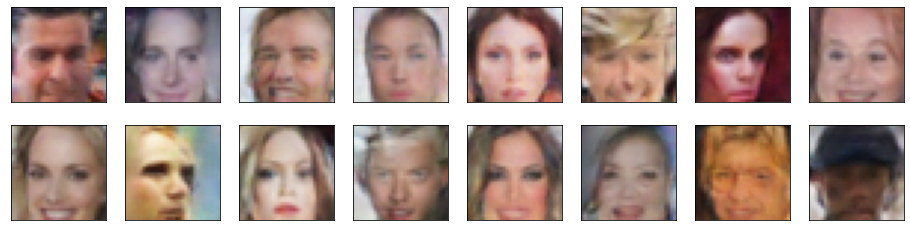

In [26]:
view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

The dataset is indeed biased - the majority of the ~90K images are of white celebrities taken with studio lighting and flash photography (sunglasses are a common feature!). The effect of this can be seen during training as we see some faces turning whiter with each epoch.

As the model trains we see repeating features across several images - the same raised eyebrow, the same hairline, etc. We also notice that during training, the images continue to evolve, with some of the images morphing into an entirely different face. An example of this being sunglasses that appear and then disappear.

To generate better quality images, we increase the model size by increasing the number of convolutional layers, and increasing the depth of each layer. We have doubled the depth of each layer, to try to learn more features. We could improve the quality further by using higher resolution images. The supplied images are 64x64 so we could input and output the same resolution. We could also change the padding and normalization to generate higher-resolution images.

The images generated during the 1st epoch are reasonable, and then seem to be fine-tuned during subsequent epochs. The learning rate appears to govern the rate of this tuning, so we apply a scheduler to reduce the learning rate every 2 epochs. We train for 20 epochs to allow for enough fine-tuning.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.